In [1]:
%config Completer.use_jedi = False

In [201]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK50_1"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

# #UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
# #distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}

mutation_arange = [np.round(x,2) for x in np.arange(0.1,1,0.2)]

In [206]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,
                                                            routingContext=routingContext,heterogeneousFleet=True)

In [3]:
from ast import literal_eval
def plot_parameter_comparison(dataframe,column_name,y_lim=None,population_size=None):
    plot_curves = []
    plot_labels = []
    for parameter_group in dataframe["Parameter Group"].unique():    
      
        parameter_group_df = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
        parameter_group_data_column = parameter_group_df[column_name]
        if type(parameter_group_data_column.iloc[0]) == str:
            parameter_group_curves = np.stack(parameter_group_data_column.apply(literal_eval).to_numpy())
        else:
            parameter_group_curves = np.stack(parameter_group_data_column.to_numpy())
   
        parameter_group_curves_mean = np.mean(parameter_group_curves,axis=0)
        plot_curves.append(parameter_group_curves_mean)
        plot_labels.append(int(parameter_group))
    
    plot_conv_curves(np.array(plot_curves),plot_labels,y_lim=y_lim)
    


def get_population_size_splits(dataframe,population_sizes=[10,20,30]):
    df_copy = deepcopy(dataframe)
    df_params = pd.DataFrame(df_copy.Parameters.apply(literal_eval).apply(dict).apply(pd.Series))
    population_sizes_dfs = []
    
    for column in df_params.columns:
        df_copy[column] = df_params[column]
    
    for population_size in population_sizes:
        
        df_pop_size = df_copy.where((df_copy.population_size == population_size) & (df_copy.mutation.isin(mutation_arange))).dropna()
        population_sizes_dfs.append(df_pop_size)
    return population_sizes_dfs


def expand_parameter_colums(dataframe):
    df_params = pd.DataFrame(dataframe.Parameters.apply(literal_eval).apply(dict).apply(pd.Series))
    for column in df_params.columns:
        dataframe[column] = df_params[column]

def add_final_fitness_columns(dataframe):
    if not "fuel_consumption_final" in dataframe.columns:
        if type(dataframe.fuel_consumption.iloc[0]) == str:
            dataframe.fuel_consumption = dataframe.fuel_consumption.apply(literal_eval)
        

        dataframe["fuel_consumption_final"] = [dataframe.fuel_consumption.loc[i][-1] for i in list(dataframe.index)]

    
    if not "longest_route_time_final" in dataframe.columns:
        if type(dataframe.vehicle_route_time.iloc[0]) == str:
            dataframe.vehicle_route_time = dataframe.vehicle_route_time.apply(literal_eval)
        dataframe["longest_route_time_final"] = [np.max(dataframe.vehicle_route_time.loc[i])/60 for i in list(dataframe.index)]
    
    
def remove_unwanted_mutation_parameter_groups(dataframe,mutation_range=mutation_arange):
    df_params = pd.DataFrame(dataframe.Parameters.apply(literal_eval).apply(dict).apply(pd.Series))
    dataframe = dataframe.where(df_params.mutation.isin(mutation_range)).dropna()
    return dataframe

In [4]:

def plot_drive_time_distribution(data, start_nodes, bar_kwargs={"SA":{"color":"#1f77b4"}, "NSGA-II": {"color":"#ff7f0e"}, "NSGAIII":{"color":"#2ca02c"}, "IBEA":{"color":"#d62728"}, "IBEA-Adaptive":{"color":"#9467bd"}, "LS":{"color":"#8c564b"}, "GA":{"color":"#e377c2"}}):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    num_bars = len(data)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
        
    for algorithm_name, offset in zip(data, offsets):
        ax.bar(np.array(range(0,len(data[algorithm_name]["vehicle_drive_times"][0].keys())))+offset, np.mean(data[algorithm_name]["drive_times_list"],axis=0), width=0.2,alpha=0.8,label=r"$\bf{%s}$" % (algorithm_name),align="center")
        plt.xticks(range(0,len(start_nodes)),labels=range(0,len(start_nodes)))
    
    
    
    plt.legend(bbox_to_anchor=(1,1))
    
    return fig, ax

In [5]:
def plot_vehicle_drivetimes(dataframe,parameter_group):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles$" % (vehicle_amount))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicles")
    
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

In [318]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def anova_plot(data,variable_field,between_fields,path=None,save=False):
    fig,ax = plt.subplots(1,1,figsize=(15,15))
    tukey = pairwise_tukeyhsd(endog=data[variable_field],groups=data[between_fields],alpha=0.05)
    tukey.plot_simultaneous(figsize=(15,15),ax=ax)
    ax.set_xlabel(variable_field,fontsize=24)
    ax.set_ylabel("Parameter Group",fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.title("")
    plt.show()
    summary = tukey.summary()
    summary_as_html = summary.as_html()
    summary_df = pd.read_html(summary_as_html, header=0, index_col=0)[0]
    summary_df.where(summary_df.reject == True,inplace=True)
    summary_df.dropna(inplace=True)
    return summary_df ,fig, tukey
    
def anova_test(data,variable_field,between_fields):
    aov = pg.anova(dv=variable_field,between = between_fields,data=data,detailed=True)
    return aov
def extractOptimalParameters(resultsDataFrame,tukeyResult,amount=5):
    optimalParamGroups = tukeyResult.sort_values(by='meandiff').head(amount).group2
    resultDF = pd.DataFrame(columns=resultsDataFrame.columns)
    for group in optimalParamGroups:
        resultDF = pd.concat([resultDF,(resultsDataFrame.where(resultsDataFrame["Parameter Group"] == np.float(group))).dropna()],axis=0)
    return resultDF


In [8]:
SA_data = pd.read_csv("parameter_data/{}/SA.csv".format(dataset))
GA_data = pd.read_csv("parameter_data/{}/GA.csv".format(dataset))
NSGA2_data = pd.read_csv("parameter_data/{}/NSGA2.csv".format(dataset))
NSGA3_data = pd.read_csv("parameter_data/{}/NSGA3.csv".format(dataset))
UNSGA3_data = pd.read_csv("parameter_data/{}/UNSGA3.csv".format(dataset))
IBEA_data = pd.read_csv("parameter_data/{}/IBEA.csv".format(dataset))


# SA

In [9]:
SA_data = remove_unwanted_mutation_parameter_groups(SA_data)
add_final_fitness_columns(SA_data)
expand_parameter_colums(SA_data)

In [12]:
SA_optimal_params = SA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
SA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation
Parameter Group,,,,
4.0,14.5,226.218534,219.179444,0.9
3.0,14.5,230.652629,218.427222,0.7
2.0,14.5,231.865315,232.059444,0.5
1.0,14.5,240.444773,232.420000,0.3
0.0,14.5,260.032957,257.448889,0.1


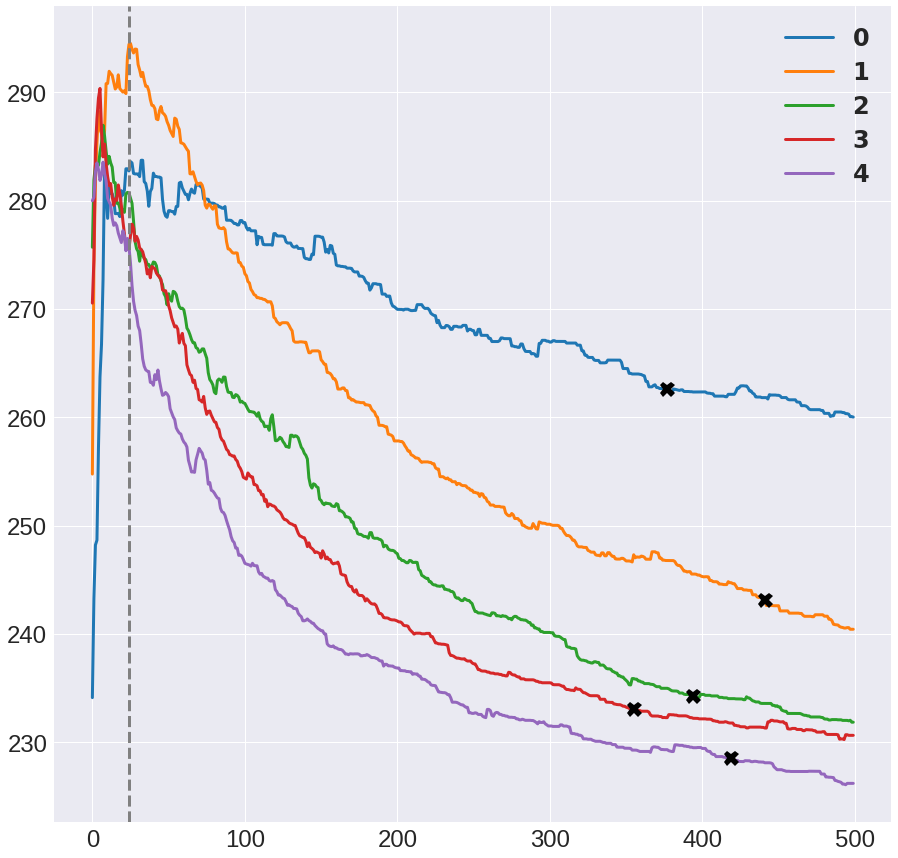

In [13]:
plot_parameter_comparison(SA_data,"fuel_consumption")

# GA

In [15]:
GA_data = remove_unwanted_mutation_parameter_groups(GA_data)
add_final_fitness_columns(GA_data)
expand_parameter_colums(GA_data)
GA_data_10pop, GA_data_20pop, GA_data_30pop = get_population_size_splits(GA_data)

In [16]:
GA_optimal_params = GA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
GA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size
Parameter Group,,,,,,
43.0,14.5,219.413956,221.156667,0.9,0.75,20.0
37.0,14.5,220.607934,219.108889,0.9,0.25,20.0
34.0,14.5,221.017762,214.131111,0.7,0.75,20.0
44.0,14.5,222.091801,215.311111,0.9,0.75,30.0
38.0,14.5,222.679871,213.208333,0.9,0.25,30.0


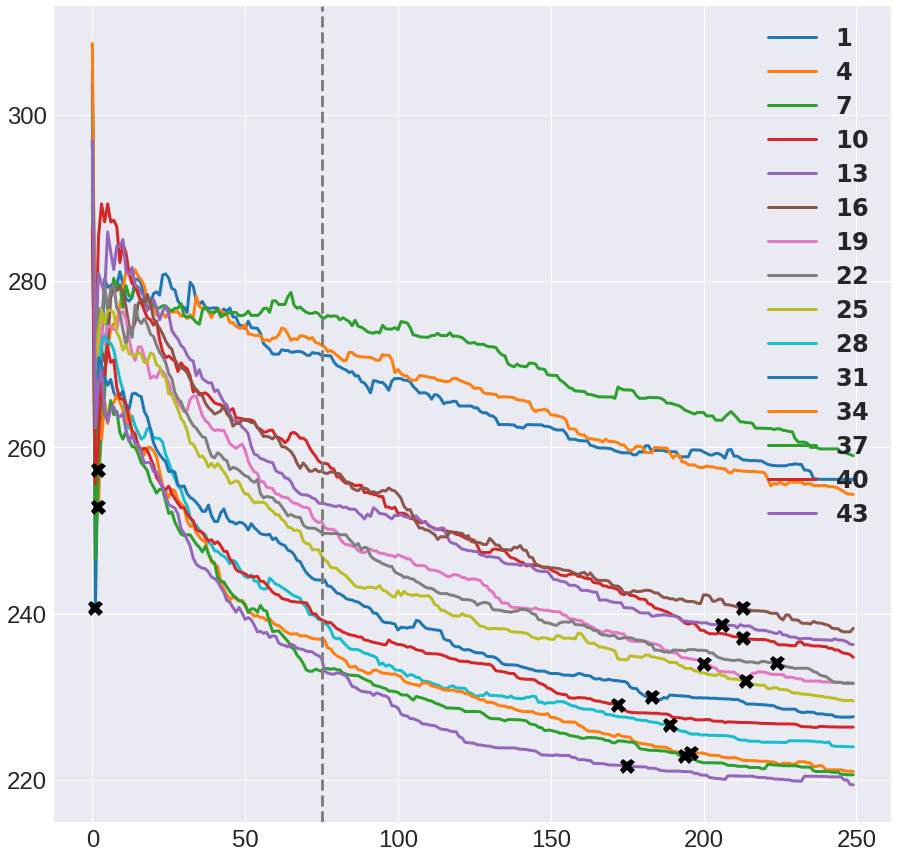

In [21]:
plot_parameter_comparison(GA_data_20pop,"fuel_consumption")

# NSGA-II

In [18]:
NSGA2_data = remove_unwanted_mutation_parameter_groups(NSGA2_data)
add_final_fitness_columns(NSGA2_data)
expand_parameter_colums(NSGA2_data)
NSGA2_data_10pop, NSGA2_data_20pop, NSGA2_data_30pop = get_population_size_splits(NSGA2_data)

In [19]:
NSGA2_optimal_params = NSGA2_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
NSGA2_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size
Parameter Group,,,,,,
31.0,14.5,215.351036,286.907778,0.7,0.50,20.0
35.0,14.5,215.769647,305.431667,0.7,0.75,30.0
44.0,14.5,216.101570,284.197778,0.9,0.75,30.0
40.0,14.5,216.228963,287.757778,0.9,0.50,20.0
28.0,14.5,216.880158,283.877778,0.7,0.25,20.0


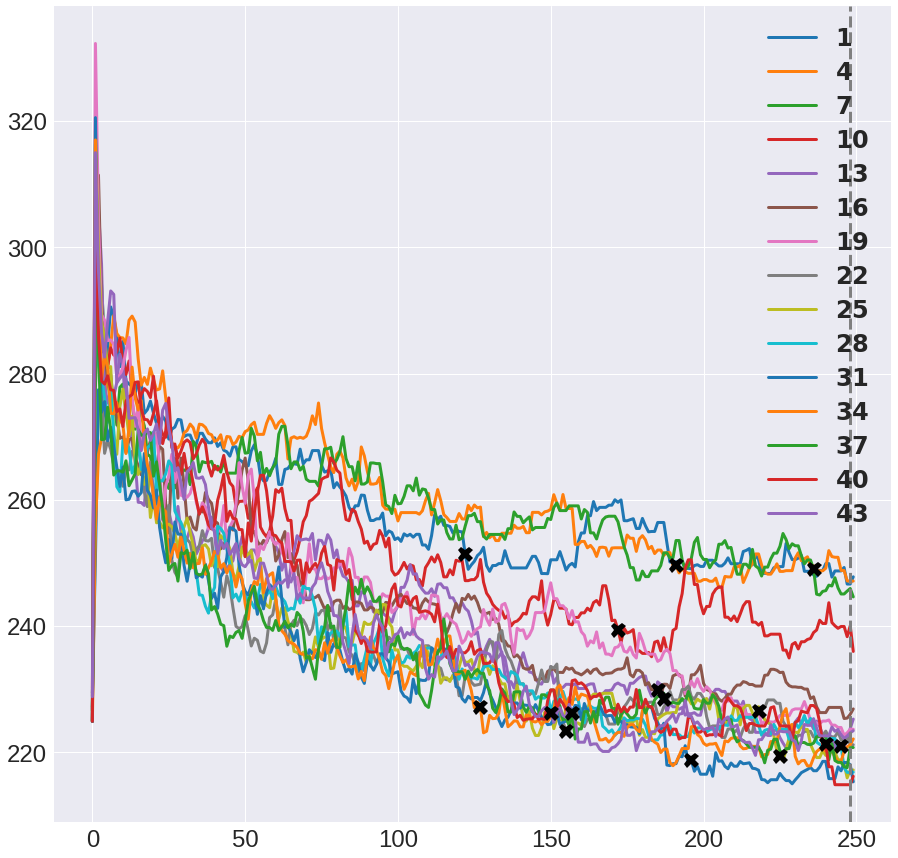

In [25]:
plot_parameter_comparison(NSGA2_data_20pop,"fuel_consumption")

# NSGA-III

In [26]:
NSGA3_data = remove_unwanted_mutation_parameter_groups(NSGA3_data)
add_final_fitness_columns(NSGA3_data)
expand_parameter_colums(NSGA3_data)
NSGA3_data_10pop, NSGA3_data_20pop, NSGA3_data_30pop = get_population_size_splits(NSGA3_data)

In [27]:
NSGA3_optimal_params = NSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
NSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size
Parameter Group,,,,,,
29.0,14.5,216.539469,274.135556,0.7,0.25,30.0
43.0,14.5,217.499241,246.615000,0.9,0.75,20.0
32.0,14.5,217.928492,267.922778,0.7,0.50,30.0
37.0,14.5,217.950173,276.646667,0.9,0.25,20.0
35.0,14.5,218.221182,255.929444,0.7,0.75,30.0


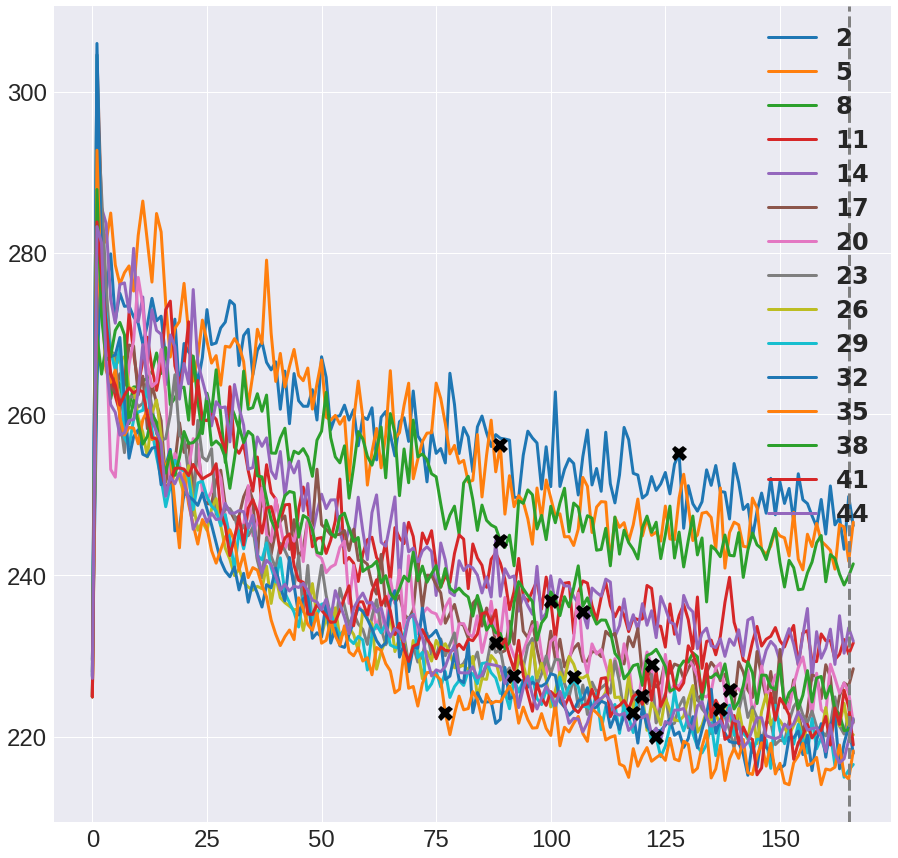

In [30]:
plot_parameter_comparison(NSGA3_data_30pop,"fuel_consumption")

# UNSGA-III

In [31]:
UNSGA3_data = remove_unwanted_mutation_parameter_groups(UNSGA3_data)
add_final_fitness_columns(UNSGA3_data)
expand_parameter_colums(UNSGA3_data)
UNSGAIII_data_10pop, UNSGAIII_data_20pop, UNSGAIII_data_30pop = get_population_size_splits(UNSGA3_data)

In [32]:
UNSGA3_optimal_params = UNSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
UNSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size
Parameter Group,,,,,,
34.0,14.5,216.842602,252.547778,0.7,0.75,20.0
35.0,14.5,216.845682,260.710000,0.7,0.75,30.0
42.0,14.5,216.855679,287.836111,0.9,0.75,10.0
40.0,14.5,217.422719,261.926111,0.9,0.50,20.0
37.0,14.5,218.525211,251.932222,0.9,0.25,20.0


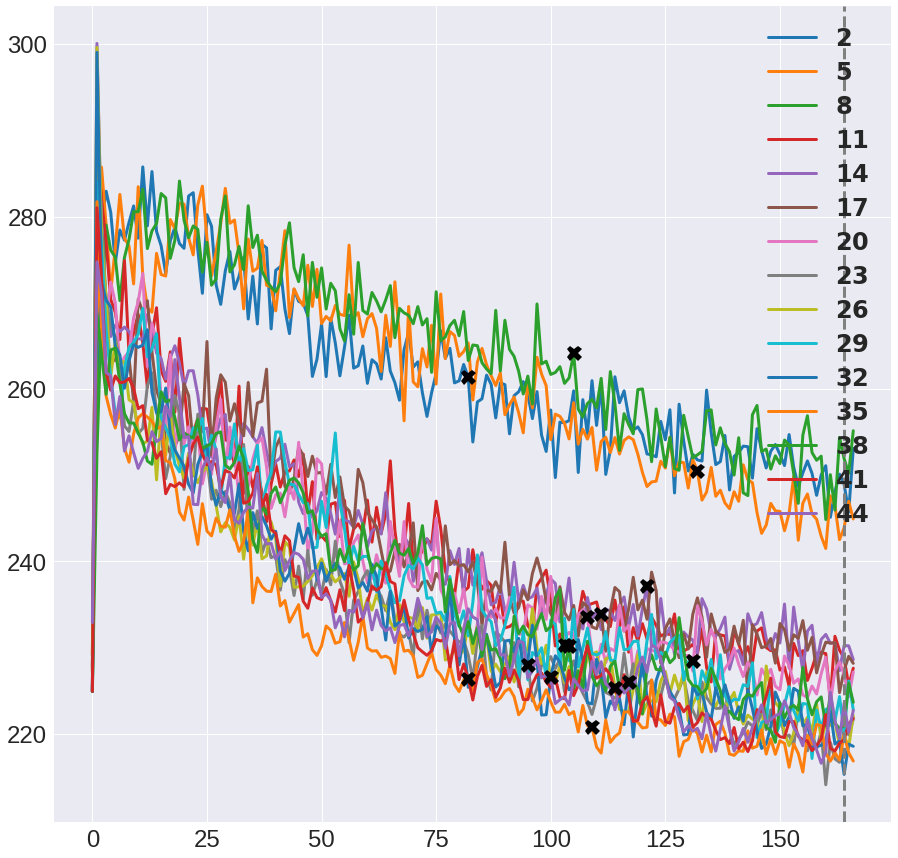

In [37]:
plot_parameter_comparison(UNSGAIII_data_30pop,"fuel_consumption")

# IBEA

In [38]:
IBEA_data = remove_unwanted_mutation_parameter_groups(IBEA_data)
add_final_fitness_columns(IBEA_data)
expand_parameter_colums(IBEA_data)
IBEA_data_10pop, IBEA_data_20pop, IBEA_data_30pop = get_population_size_splits(IBEA_data)

In [39]:
IBEA_optimal_params = IBEA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
IBEA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head()

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size
Parameter Group,,,,,,
34.0,14.5,215.857146,254.116667,0.7,0.75,20.0
29.0,14.5,216.284778,260.162222,0.7,0.25,30.0
42.0,14.5,216.362117,265.528889,0.9,0.75,10.0
35.0,14.5,216.453622,266.867778,0.7,0.75,30.0
23.0,14.5,216.466472,264.661667,0.5,0.50,30.0


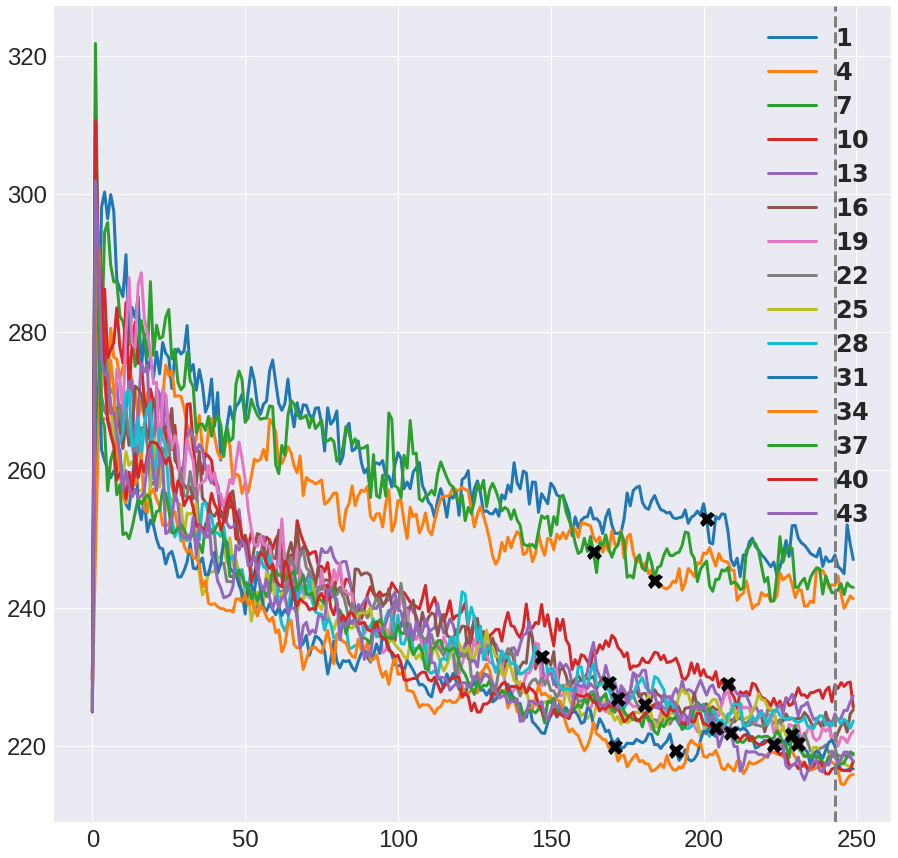

In [43]:
plot_parameter_comparison(IBEA_data_20pop,"fuel_consumption")

# Compare algorithms

In [44]:
SA_optimal_params.iloc[0].name

4.0

In [237]:
SA_optimal_params_logs = SA_data.where(SA_data["Parameter Group"] == SA_optimal_params.iloc[0].name).dropna()
SA_optimal_params_logs["Algorithm"] = "SA"
SA_fuel_consumption = np.mean(np.stack(SA_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

GA_optimal_params_logs = GA_data.where(GA_data["Parameter Group"] == GA_optimal_params.iloc[0].name).dropna()
GA_optimal_params_logs["Algorithm"] = "GA"
GA_fuel_consumption = np.mean(np.stack(GA_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

NSGA2_optimal_params_logs = NSGA2_data.where(NSGA2_data["Parameter Group"] == NSGA2_optimal_params.iloc[0].name).dropna()
NSGA2_optimal_params_logs["Algorithm"] = "NSGA2"
NSGA2_fuel_consumption = np.mean(np.stack(NSGA2_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

NSGA3_optimal_params_logs = NSGA3_data.where(NSGA3_data["Parameter Group"] == NSGA3_optimal_params.iloc[0].name).dropna()
NSGA3_optimal_params_logs["Algorithm"] = "NSGA3"
NSGA3_fuel_consumption = np.mean(np.stack(NSGA3_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

UNSGA3_optimal_params_logs = UNSGA3_data.where(UNSGA3_data["Parameter Group"] == UNSGA3_optimal_params.iloc[0].name).dropna()
UNSGA3_optimal_params_logs["Algorithm"] = "UNSGA3"
UNSGA3_fuel_consumption = np.mean(np.stack(UNSGA3_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

IBEA_optimal_params_logs = IBEA_data.where(IBEA_data["Parameter Group"] == IBEA_optimal_params.iloc[0].name).dropna()
IBEA_optimal_params_logs["Algorithm"] = "IBEA"
IBEA_fuel_consumption = np.mean(np.stack(IBEA_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

In [238]:
NSGA3_optimal_params_logs.fitness = NSGA3_optimal_params_logs.fitness.apply(literal_eval)
NSGA3_optimal_params_logs.computation_times = NSGA3_optimal_params_logs.computation_times.apply(literal_eval)

In [229]:
GA_optimal_params_logs.fitness = GA_optimal_params_logs.fitness.apply(literal_eval)

In [243]:
NSGA3_computation_times = np.stack(NSGA3_optimal_params_logs.computation_times.to_numpy())


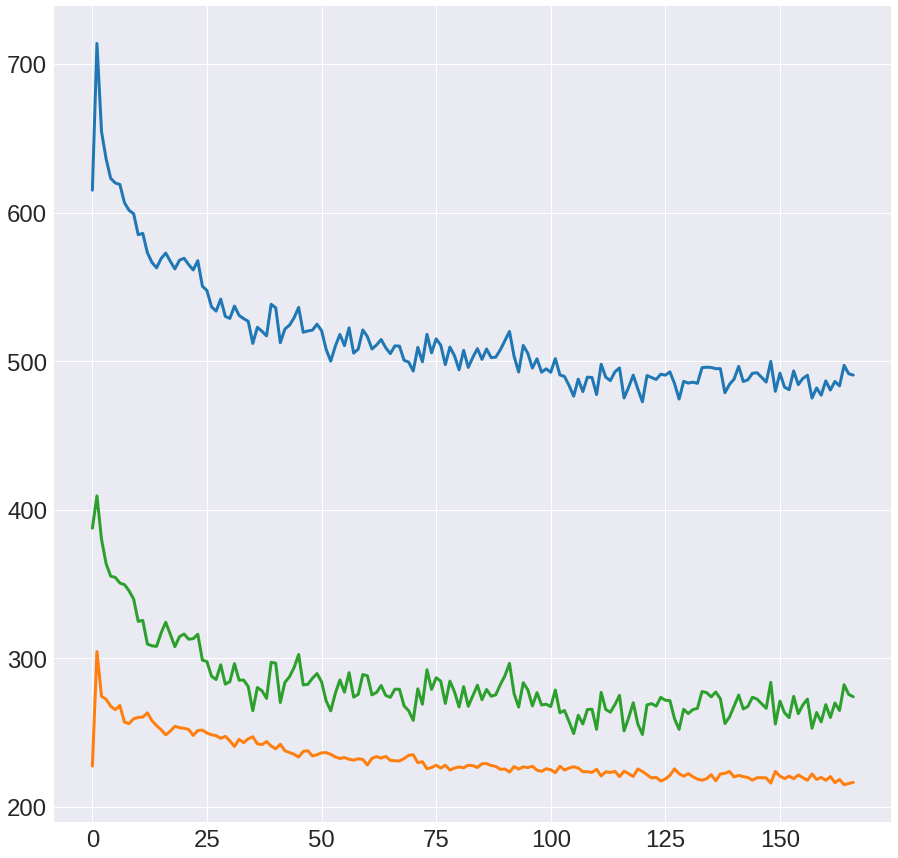

In [231]:
test = np.stack(NSGA3_optimal_params_logs.fitness.to_numpy())

plt.plot(np.mean(np.sum(test,axis=2),axis=0))
plt.plot(np.mean(test,axis=0))

In [232]:
mean_test_fuel = np.mean(test,axis=0)[:,0]
mean_test_drivetime = np.mean(test,axis=0)[:,1]

In [233]:
mean_test_fuel_minmax = (mean_test_fuel - np.min(mean_test_fuel))/(np.max(mean_test_fuel) - np.min(mean_test_fuel)) 
mean_test_drivetime_minmax = (mean_test_drivetime - np.min(mean_test_drivetime))/(np.max(mean_test_drivetime) - np.min(mean_test_drivetime)) 

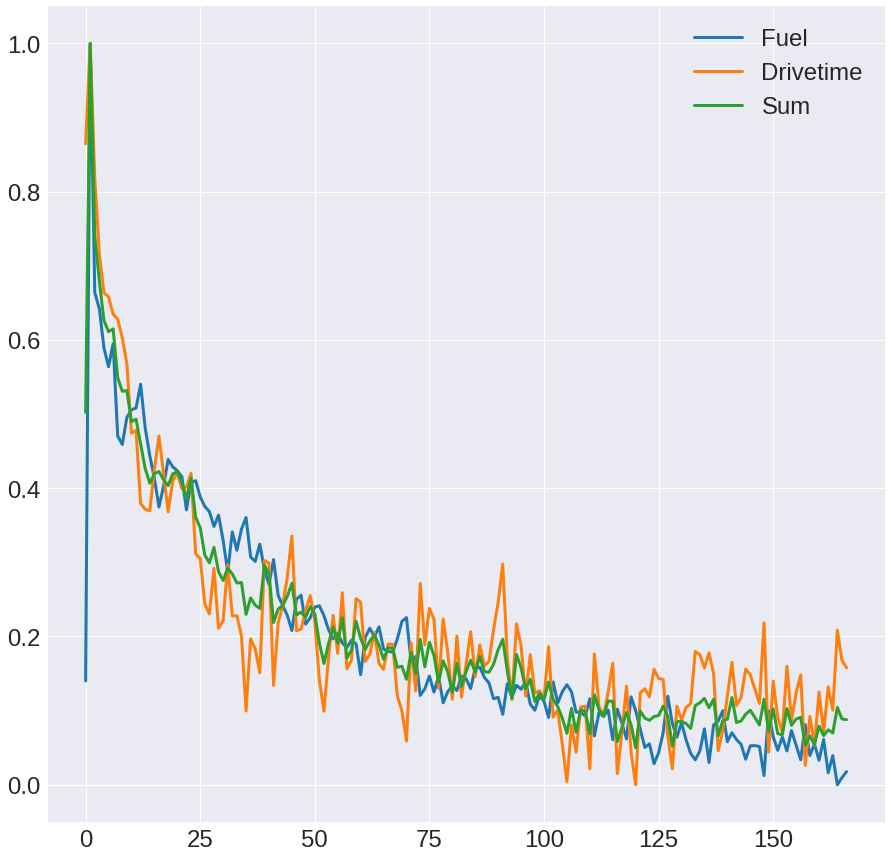

In [259]:
plt.plot(mean_test_fuel_minmax,label="Fuel")
plt.plot(mean_test_drivetime_minmax,label="Drivetime")
plt.plot((mean_test_drivetime_minmax +mean_test_fuel_minmax)/2 ,label="Sum")
plt.legend()
plt.show()

In [46]:
curves= np.array([SA_fuel_consumption,
        GA_fuel_consumption,
        NSGA2_fuel_consumption,
        NSGA3_fuel_consumption,
        UNSGA3_fuel_consumption])#,
        #IBEA_fuel_consumption])

min_length= min([len(x) for x in curves])

for index,curve in enumerate(curves):
    if len(curve) > min_length:
        print(len(curve)/min_length)
        curves[index] = curve[::int(len(curve)/min_length)]
        #print(len(curve)/min_length)

curves = np.stack(curves,axis=0)
lables = ["SA","GA","NSGAII","NSGAIII","UNSGAIII"]


plot_conv_curves(curves,lables)

2.9940119760479043
1.4970059880239521
1.4970059880239521
1.4970059880239521


<ipython-input-46-1bf36a75fffc>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



ValueError: all input arrays must have the same shape

In [299]:
best_NSGA2 = NSGA2_optimal_params_logs.sort_values(by=["longest_route_time_final","fuel_consumption_final"]).head(1)
best_NSGA2

,Unnamed: 0,fitness,route_distance,fuel_consumption,vehicle_loads,computation_times,vehicle_route_time,violation,paths,Parameter Group,Parameters,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,Algorithm
937,7.0,"[[224.92657892236454, 388.25], [344.0659479932...","[127215, 149872, 155411, 97631, 110273, 188827...","[224.92657892236454, 344.0659479932836, 344.06...","[array([ 0., 602., 603., 537., 141., 825., 81...","[0.01738452911376953, 0.04042387008666992, 0.0...","[10351, 9557, 10117, 8719, 12282, 12325, 11785...","[-221.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[['V0', 42, 33, 30, 34, 19, 29, 2], ['V2', 24,...",31.0,"[('mutation', 0.7), ('crossover', 0.5), ('popu...",212.655191,209.8,0.7,0.5,20.0,NSGA2


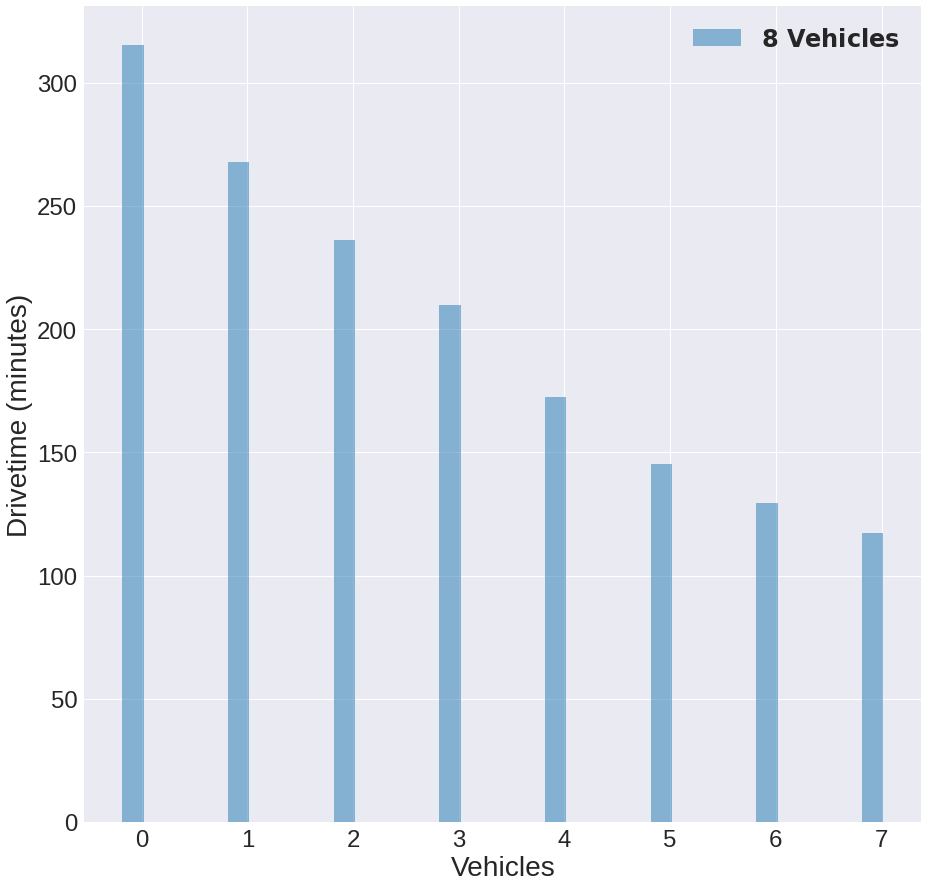

In [281]:
plot_vehicle_drivetimes(best_NSGA2,29)

In [294]:
test3 = NSGA2_optimal_params_logs[["fuel_consumption_final","longest_route_time_final"]]

In [295]:
test3_np = test3.to_numpy()

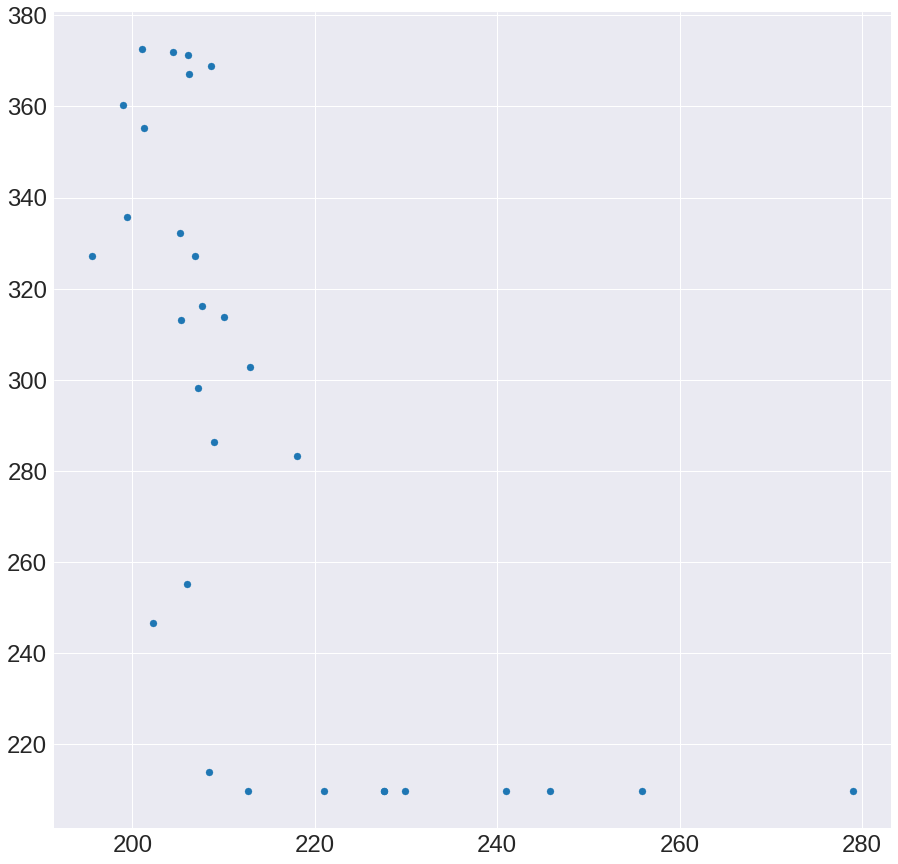

In [296]:
#plt.scatter(test3_np[:,0],test3_np[:,1])

In [304]:
NSGA2_optimal_params_logs["distance_to_origo"] = ((NSGA2_optimal_params_logs.fuel_consumption_final**2) + (NSGA2_optimal_params_logs.longest_route_time_final**2))**0.5

In [308]:
def add_distance_to_origin(dataframe):
    dataframe["distance_to_origin"] = ((dataframe.fuel_consumption_final**2) + (dataframe.longest_route_time_final**2))**0.5

In [309]:
add_distance_to_origin(NSGA2_data)

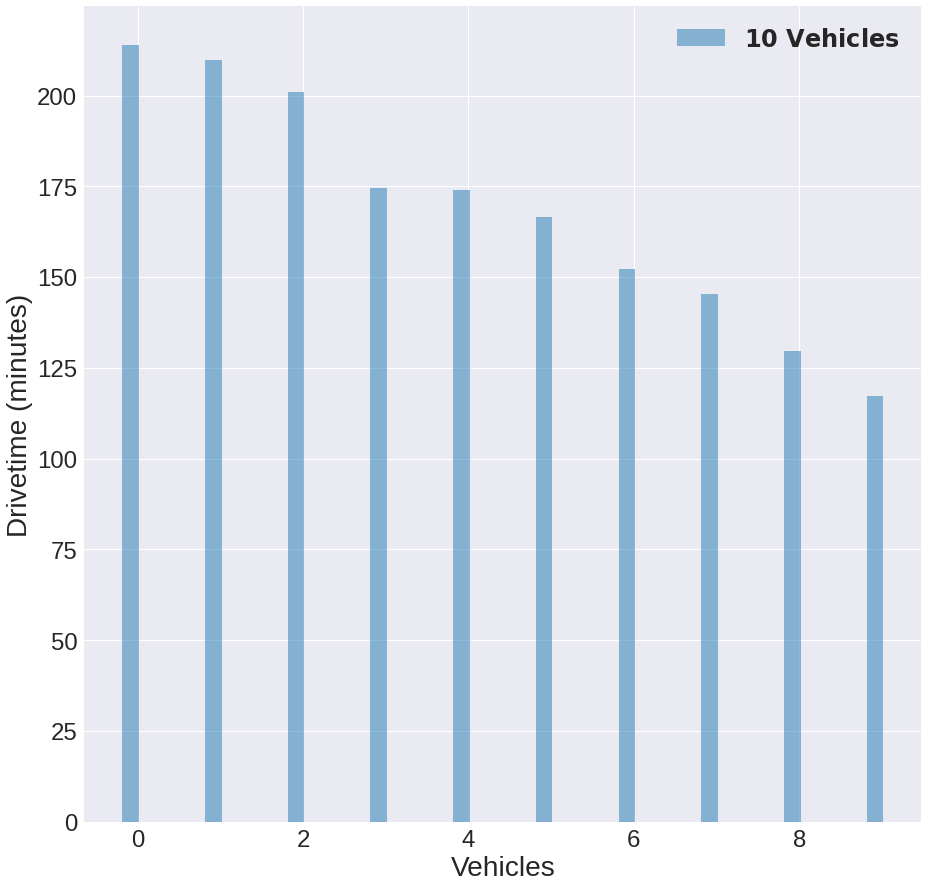

In [307]:
plot_vehicle_drivetimes(NSGA2_optimal_params_logs.sort_values(by=["distance_to_origo"]).head(1),31)

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



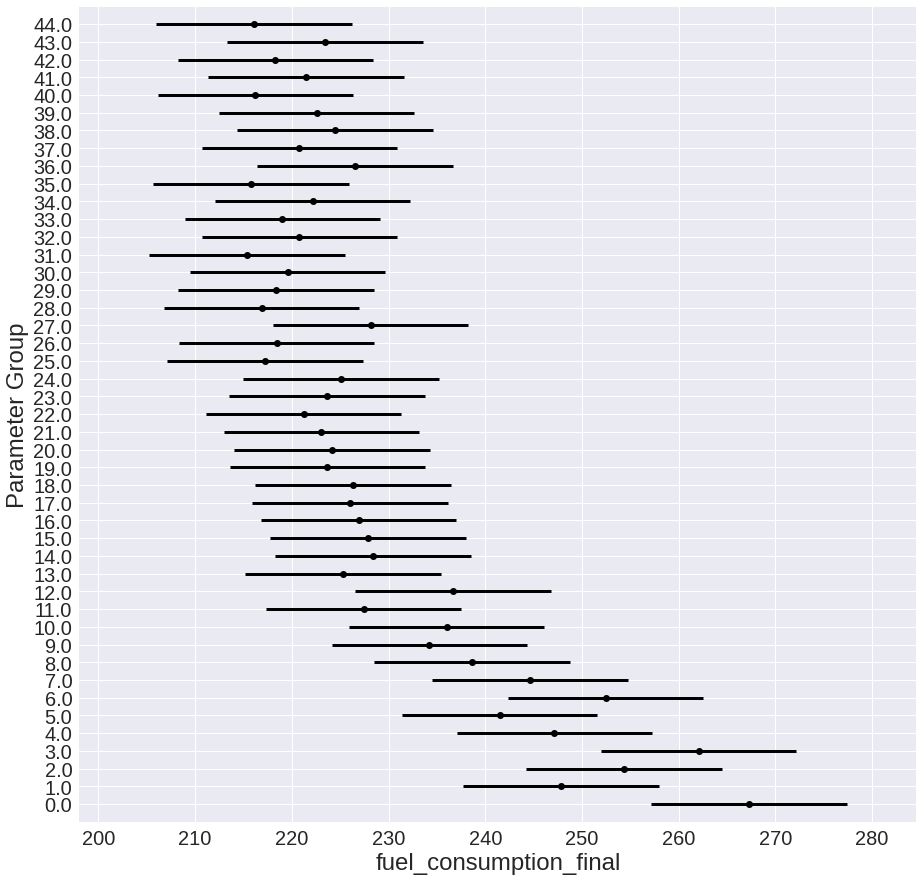

(        group2  meandiff   p-adj    lower    upper  reject
 group1                                                    
 0.0        5.0  -25.7535  0.0010 -45.9732  -5.5339     1.0
 0.0        7.0  -22.6052  0.0083 -42.8249  -2.3855     1.0
 0.0        8.0  -28.5989  0.0010 -48.8186  -8.3793     1.0
 0.0        9.0  -33.0162  0.0010 -53.2359 -12.7965     1.0
 0.0       10.0  -31.2399  0.0010 -51.4596 -11.0202     1.0
 ...        ...       ...     ...      ...      ...     ...
 10.0      35.0  -20.2328  0.0496 -40.4525  -0.0131     1.0
 12.0      31.0  -21.2938  0.0232 -41.5135  -1.0741     1.0
 12.0      35.0  -20.8752  0.0316 -41.0949  -0.6555     1.0
 12.0      40.0  -20.4159  0.0438 -40.6356  -0.1962     1.0
 12.0      44.0  -20.5433  0.0401 -40.7630  -0.3236     1.0
 
 [252 rows x 6 columns],
 <Figure size 1080x1080 with 1 Axes>,
 <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7f9e9ff06970>)

In [313]:
anova_plot(NSGA2_data,"fuel_consumption_final","Parameter Group")

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



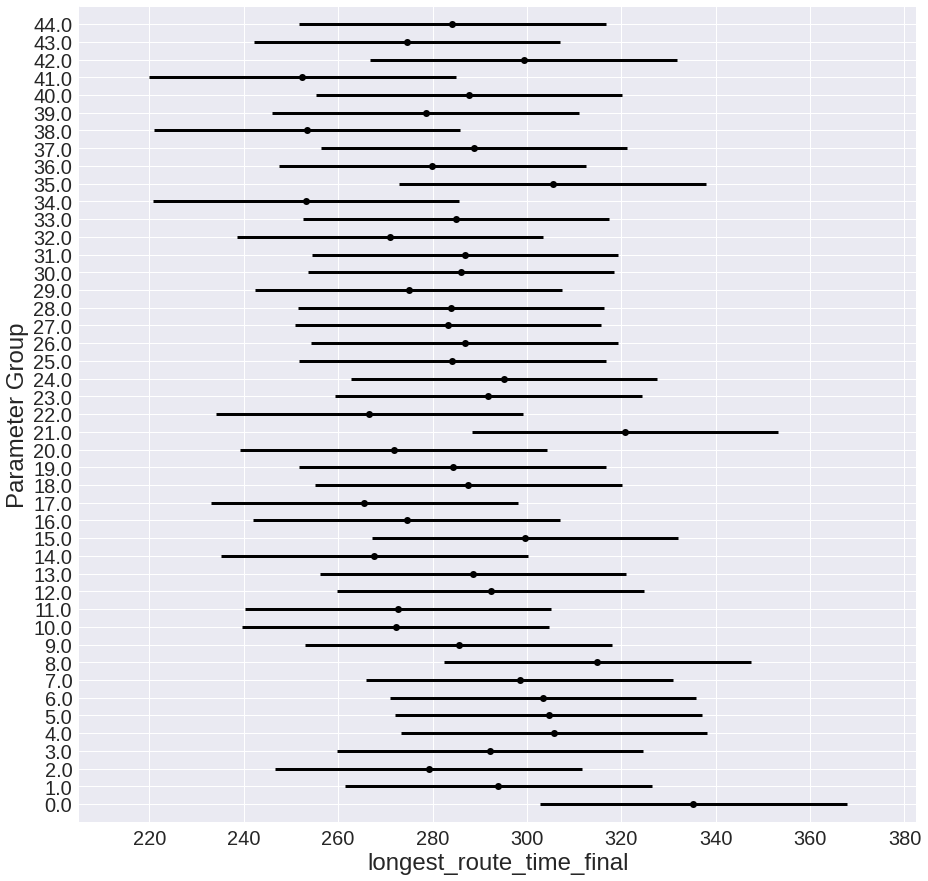

(        group2  meandiff   p-adj     lower    upper  reject
 group1                                                     
 0.0       14.0  -67.5900  0.0280 -132.5378  -2.6422     1.0
 0.0       17.0  -69.7228  0.0170 -134.6706  -4.7750     1.0
 0.0       22.0  -68.6117  0.0221 -133.5595  -3.6638     1.0
 0.0       34.0  -82.1067  0.0010 -147.0545 -17.1588     1.0
 0.0       38.0  -81.8722  0.0010 -146.8200 -16.9244     1.0
 0.0       41.0  -82.8361  0.0010 -147.7839 -17.8883     1.0
 21.0      34.0  -67.6556  0.0275 -132.6034  -2.7077     1.0
 21.0      38.0  -67.4211  0.0291 -132.3689  -2.4733     1.0
 21.0      41.0  -68.3850  0.0233 -133.3328  -3.4372     1.0,
 <Figure size 1080x1080 with 1 Axes>,
 <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7f9e9dd1cee0>)

In [314]:
anova_plot(NSGA2_data,"longest_route_time_final","Parameter Group")

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



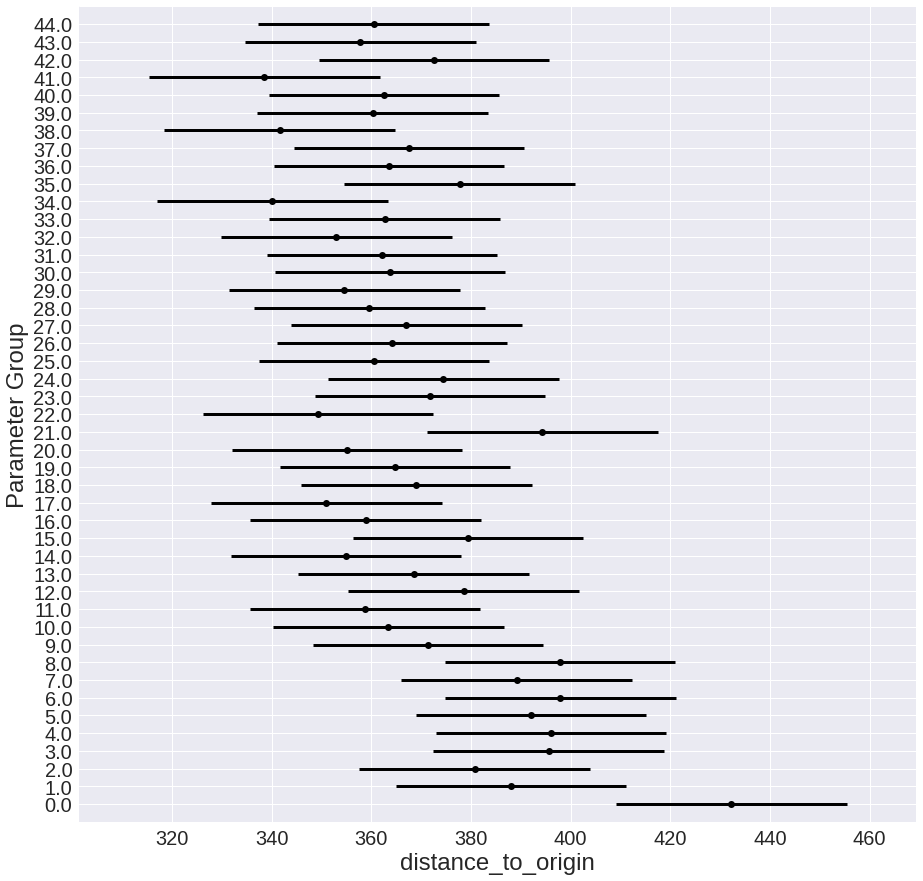

(        group2  meandiff   p-adj     lower    upper  reject
 group1                                                     
 0.0        2.0  -51.4737  0.0091  -97.7511  -5.1964     1.0
 0.0        9.0  -60.8535  0.0010 -107.1309 -14.5761     1.0
 0.0       10.0  -68.8067  0.0010 -115.0840 -22.5293     1.0
 0.0       11.0  -73.4664  0.0010 -119.7438 -27.1890     1.0
 0.0       12.0  -53.6682  0.0041  -99.9455  -7.3908     1.0
 ...        ...       ...     ...       ...      ...     ...
 8.0       38.0  -56.2354  0.0015 -102.5127  -9.9580     1.0
 8.0       41.0  -59.3034  0.0010 -105.5808 -13.0260     1.0
 21.0      34.0  -54.2250  0.0033 -100.5023  -7.9476     1.0
 21.0      38.0  -52.7321  0.0058  -99.0095  -6.4547     1.0
 21.0      41.0  -55.8001  0.0018 -102.0775  -9.5228     1.0
 
 [65 rows x 6 columns],
 <Figure size 1080x1080 with 1 Axes>,
 <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7f9e9f424bb0>)

In [315]:
anova_plot(NSGA2_data,"distance_to_origin","Parameter Group")

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



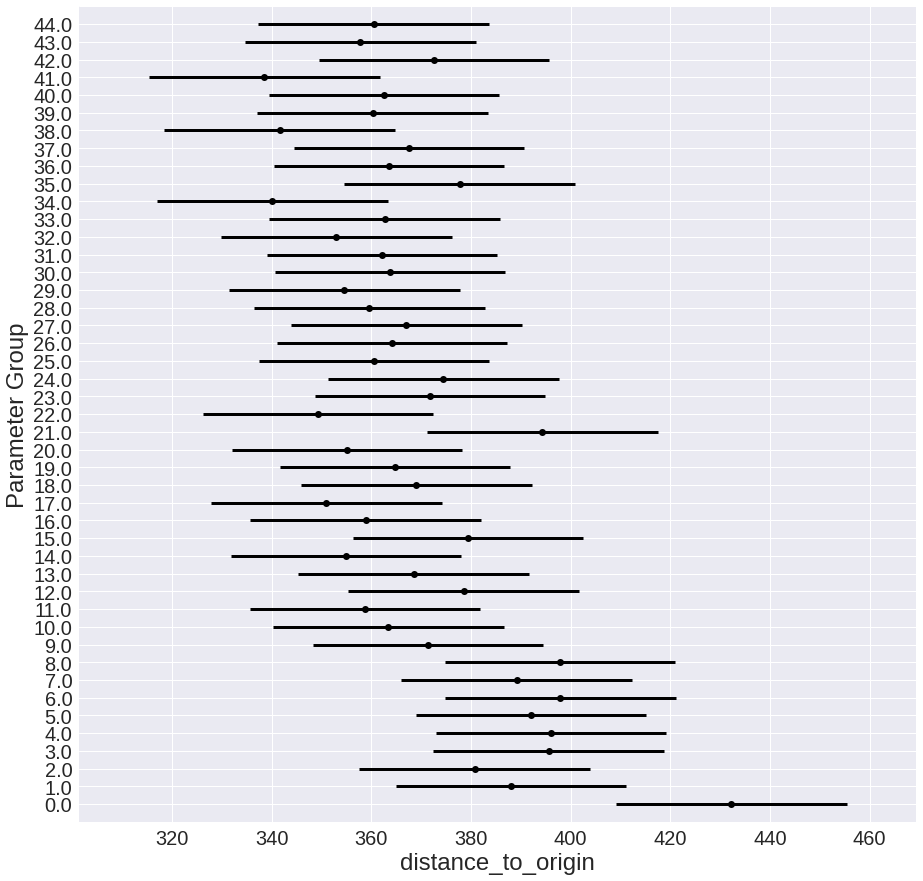

In [319]:
nsga2_data_tukey,fig,_ = anova_plot(NSGA2_data,"distance_to_origin","Parameter Group")
nsga2_data_optimal = extractOptimalParameters(NSGA2_data,nsga2_data_tukey,1)


In [320]:
nsga2_data_optimal

,Unnamed: 0,fitness,route_distance,fuel_consumption,vehicle_loads,computation_times,vehicle_route_time,violation,paths,Parameter Group,Parameters,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size,distance_to_origin
1230,0.0,"[[293.936870654293, 380.3333333333333], [281.1...","[138599, 200689, 142284, 109304, 102533, 16418...","[293.936870654293, 281.17360900325303, 245.241...","[array([ 0., 602., 537., 603., 825., 141., 80...","[0.021849393844604492, 0.05380368232727051, 0....","[10391, 11247, 9996, 9676, 12228, 9625, 12529,...","[-221.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[['V0', 42, 30, 33, 19, 34, 27, 2], ['V2', 24,...",41.0,"[('mutation', 0.9), ('crossover', 0.5), ('popu...",222.554141,209.800000,0.9,0.5,30.0,305.853536
1231,1.0,"[[224.92657892236454, 388.25], [236.7653502689...","[129339, 194798, 97631, 234691, 149837, 243437...","[224.92657892236454, 236.7653502689282, 236.76...","[array([ 0., 602., 603., 537., 825., 141., 81...","[0.02106165885925293, 0.054837703704833984, 0....","[10076, 13866, 8719, 20227, 11025, 14318, 1258...","[-221.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[['V0', 42, 33, 30, 19, 34, 29, 2], ['V2', 48,...",41.0,"[('mutation', 0.9), ('crossover', 0.5), ('popu...",206.165682,337.116667,0.9,0.5,30.0,395.160645
1232,2.0,"[[224.92657892236454, 388.25], [250.5366666758...","[129110, 192646, 158856, 97631, 93160, 207314,...","[224.92657892236454, 250.5366666758564, 250.53...","[array([ 0., 602., 537., 603., 825., 141., 31...","[0.021083354949951172, 0.051415443420410156, 0...","[10477, 12073, 11220, 8719, 11335, 12517, 4033...","[-221.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[['V0', 42, 30, 33, 19, 34, 16, 2], ['V2', 37,...",41.0,"[('mutation', 0.9), ('crossover', 0.5), ('popu...",230.905580,209.800000,0.9,0.5,30.0,311.983055
1233,3.0,"[[224.92657892236454, 388.25], [275.9539999572...","[129339, 276712, 72069, 97631, 212447, 169726,...","[224.92657892236454, 275.95399995722653, 228.8...","[array([ 0., 602., 603., 537., 825., 141., 81...","[0.02212667465209961, 0.053809165954589844, 0....","[10076, 17775, 8989, 8719, 15614, 13071, 7774,...","[-221.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[['V0', 42, 33, 30, 19, 34, 29, 2], ['V2', 48,...",41.0,"[('mutation', 0.9), ('crossover', 0.5), ('popu...",213.797562,296.250000,0.9,0.5,30.0,365.340198
1234,4.0,"[[224.92657892236454, 388.25], [256.0605830080...","[133679, 145150, 145729, 97631, 102313, 222939...","[224.92657892236454, 256.06058300802584, 256.0...","[array([ 0., 602., 537., 603., 825., 141., 81...","[0.02004861831665039, 0.05231213569641113, 0.0...","[10513, 8546, 11099, 8719, 11492, 12392, 2156,...","[-221.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[['V0', 42, 30, 33, 19, 34, 29, 2], ['V3', 37,...",41.0,"[('mutation', 0.9), ('crossover', 0.5), ('popu...",227.092261,209.800000,0.9,0.5,30.0,309.171369
1235,5.0,"[[224.92657892236454, 388.25], [352.0935648160...","[128494, 234972, 109304, 88706, 154888, 155468...","[224.92657892236454, 352.0935648160137, 273.67...","[array([ 0., 602., 537., 603., 825., 141., 81...","[0.020170211791992188, 0.051744699478149414, 0...","[11359, 14782, 9676, 10830, 10245, 11785, 1390...","[-221.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[['V1', 42, 30, 33, 19, 34, 29, 24, 2], ['V2',...",41.0,"[('mutation', 0.9), ('crossover', 0.5), ('popu...",213.401693,246.366667,0.9,0.5,30.0,325.939898
1236,6.0,"[[224.92657892236454, 388.25], [392.0600446377...","[137243, 161354, 155411, 97631, 195695, 180808...","[224.92657892236454, 392.06004463779766, 294.7...","[array([ 0., 602., 537., 603., 141., 825., 81...","[0.021325111389160156, 0.05329704284667969, 0....","[10778, 10217, 10117, 8719, 10043, 12192, 1211...","[-221.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[['V1', 42, 30, 33, 34, 19, 29, 2], ['V2', 31,...",41.0,"[('mutation', 0.9), ('crossover', 0.5), ('popu...",252.361758,209.800000,0.9,0.5,30.0,328.180586
1237,7.0,"[[224.92657892236454, 388.25], [288.6771831695...","[